# Inverted Pendulum

Observations:
* Agents do better without batchnorm, because of the linearity of the objective function
* The optimal action is always $action = -state$
* With batchnorm, agents lose information about where in state space they are

In [1]:
from agentflow.env import VecGymEnv
from agentflow.agents import DDPG
from agentflow.buffers import BufferMap
from agentflow.state import NPrevFramesStateEnv
from agentflow.tensorflow.nn import dense_net
from agentflow.tensorflow.ops import normalize_ema
from agentflow.utils import check_whats_connected
import tensorflow as tf
import numpy as np
import pandas as pd

In [2]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

Populating the interactive namespace from numpy and matplotlib


## Settings


In [3]:
env_id = 'Pendulum-v0'
dqda_clipping = 1
clip_norm = True
hidden_dims = 32
hidden_layers = 2
output_dim = 1
batchnorm = True

## Build Environment & Agent

In [4]:
def dense_net(x,units,layers,batchnorm=True,activation=tf.nn.relu,training=False,**kwargs):

    assert isinstance(layers,int) and layers > 0, 'layers should be a positive integer'
    assert isinstance(units,int) and units > 0, 'units should be a positive integer'

    h = x
    for l in range(layers):
        h = tf.layers.dense(h,units,**kwargs)
        h = activation(h)
        
        if batchnorm:
            BN = tf.layers.BatchNormalization()
            h = BN(h,training=training)
    return h

In [5]:
def build_net_fn(hidden_dims,hidden_layers,output_dim,batchnorm):
    def net_fn(state,training=False):
        h = state
        if batchnorm:
            BN = tf.layers.BatchNormalization()
            h = BN(h,training=training)
        
            #with tf.control_dependencies(BN.updates):
            h = dense_net(h,hidden_dims,hidden_layers,batchnorm=batchnorm,training=training)
        else:
            h = dense_net(h,hidden_dims,hidden_layers,batchnorm=False,training=training)
            
        return tf.layers.dense(h,output_dim)
    return net_fn

def build_policy_fn(*args,**kwargs):
    net_fn = build_net_fn(*args,**kwargs)
    def policy_fn(state,training=False):
        h = net_fn(state)
        return 2*tf.nn.tanh(h)
    return policy_fn

def build_q_fn(*args,**kwargs):
    net_fn = build_net_fn(*args,**kwargs)
    def q_fn(state,action,training=False):
        h = tf.concat([state,action],axis=1)
        return net_fn(h)
    return q_fn

#### environment

In [6]:
env = VecGymEnv(env_id,n_envs=10)
env = NPrevFramesStateEnv(env,n_prev_frames=4,flatten=True)

test_env = NPrevFramesStateEnv(VecGymEnv(env_id,n_envs=1),n_prev_frames=4,flatten=True)

state = env.reset()
state_shape = state.shape
action_shape = env.env.action_shape()
state_shape, action_shape

((10, 12), (10, 1))

#### neural nets

In [7]:
policy_fn = build_policy_fn(hidden_dims,hidden_layers,output_dim,batchnorm)
q_fn = build_q_fn(hidden_dims,hidden_layers,output_dim,batchnorm)

#### agent

In [8]:
tf.reset_default_graph()
agent = DDPG(state_shape[1:],action_shape[1:],policy_fn,q_fn,dqda_clipping,clip_norm)
replay_buffer = BufferMap()

W1002 19:26:20.359115 4631799232 deprecation_wrapper.py:119] From /Users/justinmaojones/rl/agentflow/agents/ddpg.py:40: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1002 19:26:20.379813 4631799232 deprecation_wrapper.py:119] From /Users/justinmaojones/rl/agentflow/agents/ddpg.py:55: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1002 19:26:20.458847 4631799232 deprecation.py:323] From <ipython-input-4-b7b951101ec6>:8: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W1002 19:26:20.461266 4631799232 deprecation.py:506] From /Users/justinmaojones/rl/env/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer

## Train Agent

In [9]:
def test_agent(test_env,agent):
    state, rt, done = test_env.reset(), 0, 0
    while np.sum(done) == 0:
        state, reward, done, _ = test_env.step(agent.act(state))
        rt += reward.sum()
    return rt

In [10]:
VARVALS = {v.name:tf.reduce_mean(tf.square(v)) for v in tf.global_variables()}

In [11]:
reward_history = []
action_history = []
variable_vals = []
test_ep_returns = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    B = int(1e3)
    T = int(1e5)
    batchsize = 100
    pb = tf.keras.utils.Progbar(T)
    for t in range(T):
        
        action = agent.act(state)
        if len(replay_buffer) > B:
            action += 0.1*np.random.randn(*action.shape)
        else:
            action = np.random.randn(*action.shape)
        
        state2, reward, done, info = env.step(action)
        
        reward_history.append(reward)
        action_history.append(action)
        
        replay_buffer.append({'state':state,'action':action,'reward':reward,'done':done,'state2':state2})
        state = state2
        
        if len(replay_buffer) > B:
            agent.update(**replay_buffer.sample(batchsize))
            
        #variable_vals.append(sess.run(VARVALS))
            
        if t % 1000 == 0 and t > 0:
            test_ep_returns.append(test_agent(test_env,agent))
            
            pb.add(1,[('avg_reward', reward.mean()),('test_ep_returns', test_ep_returns[-1])])
        else:
            
            pb.add(1,[('avg_reward', reward.mean())])
        

100000/100000 [==============================] - 300s 3ms/step - avg_reward: -1.4593 - test_ep_returns: -323.5625


In [12]:
reward_history_arr = np.stack(reward_history)
action_history_arr = np.stack(action_history)
variable_vals_df = pd.DataFrame(variable_vals)
test_ep_returns_arr = np.stack(test_ep_returns)

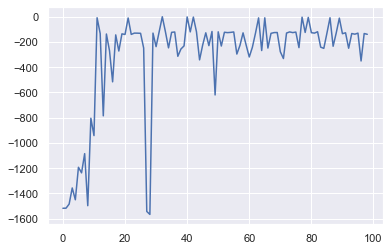

In [13]:
plt.plot(test_ep_returns_arr)

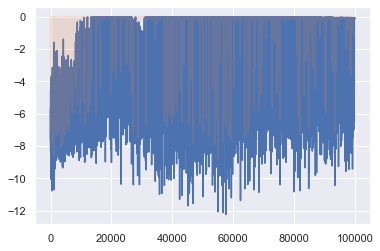

In [14]:
plt.plot(reward_history_arr.mean(axis=1))
plt.plot(reward_history_arr.max(axis=1),alpha=0.2)

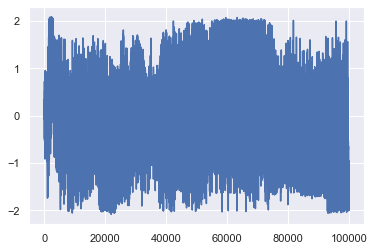

In [15]:
plt.plot(action_history_arr.mean(axis=1))

In [16]:
tf.global_variables()

[<tf.Variable 'policy/batch_normalization/gamma:0' shape=(12,) dtype=float32_ref>,
 <tf.Variable 'policy/batch_normalization/beta:0' shape=(12,) dtype=float32_ref>,
 <tf.Variable 'policy/batch_normalization/moving_mean:0' shape=(12,) dtype=float32_ref>,
 <tf.Variable 'policy/batch_normalization/moving_variance:0' shape=(12,) dtype=float32_ref>,
 <tf.Variable 'policy/dense/kernel:0' shape=(12, 32) dtype=float32_ref>,
 <tf.Variable 'policy/dense/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'policy/batch_normalization_1/gamma:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'policy/batch_normalization_1/beta:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'policy/batch_normalization_1/moving_mean:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'policy/batch_normalization_1/moving_variance:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'policy/dense_1/kernel:0' shape=(32, 32) dtype=float32_ref>,
 <tf.Variable 'policy/dense_1/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variabl

In [17]:
for c in sorted(variable_vals_df.columns):
    variable_vals_df[c].apply(np.log).plot(title=c)
    plt.show()